In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys
import scipy.io

import os
import datetime
import glob
import h5py
import copy


sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import jabble.model
import jabble.dataset
import jabble.loss
import jabble.quickplay

import astropy.coordinates as coord
import astropy.time as at
import astropy.units as u

jax.config.update("jax_enable_x64", True)

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax/','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

<h1>03-Extract Data from KOA files</h1>
In this notebook, I extract the flux, wavelength, error data from many KOA data fits file. And store the important information in arrays that will used for fitting by jabble.

In [3]:
file_names = 'KOA_68585/HIRES/extracted/**/*_flux.fits' #+ ['KOA_123937_{}/HIRES/extracted/**/*_flux.fits'.format(x) for x in range(2,16)]
folder_names = os.path.join('/scratch/mdd423/wobble_jax/data/gj436_hires',file_names)
files = glob.glob(folder_names, 
                   recursive = True)

In [4]:
hdu1 = fits.open(files[0])

In [5]:
hdu1[0].header

SIMPLE  =                    T / Java FITS: Fri Aug 08 03:28:47 HST 2008        
BITPIX  =                  -32                                                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
DATE    = '2008-03-19T11:47:49' /  file creation date (YYYY-MM-DDThh:mm:ss UT)  
DETCNFID=                 1002 / mosaic detector configuration Id               
DETCNFIG= 'HIRES Science mosaic' /  mosaic detector configuration               
MOSAIC  = 'HIRES Science Mosaic' /  mosaic detector                             
MOSDESIN= 'HIRES Mosaic'       /  mosaic detector design                        
AMPWIRES= 'HIRES Wiring, 6-amplifier' /  mosaic amplifier wiring                
VIDEOINP=                    6 / see HIRES engineering drawing H9604            
AMPLOC  = '6       '           /  see HIRES engineering drawing H9604           
AMPTYPE = 'B       '        

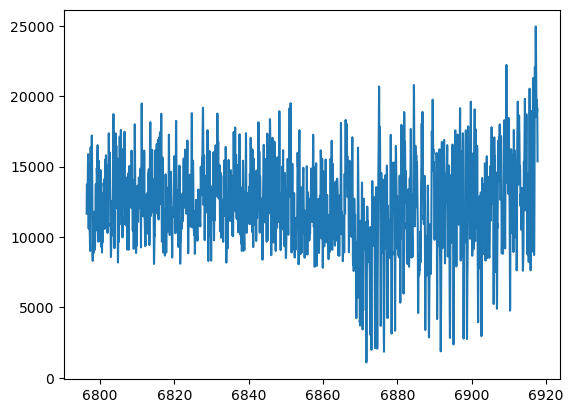

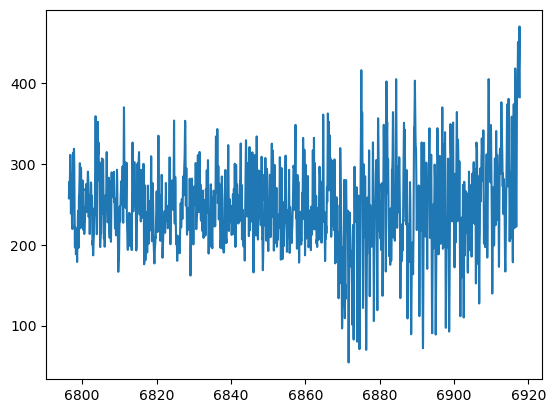

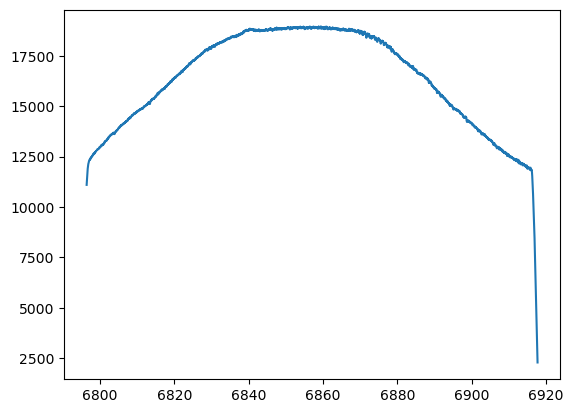

In [6]:
plt.plot(hdu1[1].data['wave'],hdu1[1].data['flux'])
plt.show()
plt.plot(hdu1[1].data['wave'],hdu1[1].data['Background'])
plt.show()
plt.plot(hdu1[1].data['wave'],hdu1[1].data['Flat'])
plt.show()

In [7]:
observatory_name = 'Keck'
loc = coord.EarthLocation.of_site(observatory_name)
star_name = hdu1[0].header['TARGNAME']
star = coord.SkyCoord.from_name(star_name,parse=True)

In [8]:
valid_target = ['36-Gl436(STD)', 'GJ 436', 'GJ436', 'HIP57087', 'gl436','gl436_M3V', 'hip 57087', 'hip57087']
valid_object = ['(Flux)', 'GJ 436 (Flux)', 'GJ 436 +I2 (Flux)', 'GJ436 (Flux)',\
        'HIP57087 (Flux)','Object (Flux)',\
        'Star+Iodine (Flux)',\
        'hip57087 (Flux)', 'k71 (Flux)', 'k72 (Flux)',\
        'k75 (Flux)', 'k80 (Flux)', 'k81 (Flux)', 'k82 (Flux)',\
        'k83 (Flux)', 'k86 (Flux)', 'k88 (Flux)', 'object (Flux)',\
        'star (Flux)']

def get_order_files(all_files):
    all_orders = []
    wavemins = []
    name_arr = []

    for filename in files:
        try:
            hdu1 = fits.open(filename)
            
            if hdu1[0].header['TARGNAME'] in valid_target:
                if hdu1[0].header['OBJECT'] in valid_object:
                    name_arr.append(filename)
                    all_orders.append(hdu1[0].header['ECHL_ORD'])
                    wavemins.append(np.min(hdu1[1].data['wave']))

            #         if hdu1[0].header['ECHL_ORD'] is echelle_order:
            #             try:
            #                 jd = '{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC'])#, format='isot', scale='utc')
            #             except:
            #                 jd = '{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT'])#, format='isot', scale='utc')
                    
            #             # print(hdu1[0].header['TARGNAME'],hdu1[0].header['OBJECT'])
                        
            #             # times.append(jd)
                        # wavemins.append(np.min(hdu1[1].data['wave']))
            #             # orders.append(hdu1[0].header['ECHL_ORD'])
                        
        except OSError:
            print(filename)
    assert len(all_orders) == len(name_arr)
    assert len(all_orders) == len(wavemins)
    
    for echelle_order in np.unique(all_orders):
        mask = np.array(all_orders) == echelle_order
        median_wave = np.median(np.array(wavemins)[mask])
        mask_waves = np.abs(np.array(wavemins) - median_wave) < 5
        total_mask = (~mask_waves.astype(bool)) * mask.astype(bool)

        indices, = np.where(total_mask)
        for index in sorted(indices,reverse=True):
            all_orders.pop(index)
            name_arr.pop(index)
            wavemins.pop(index)
    
    return name_arr, np.array(all_orders)
name_arr, all_orders = get_order_files(files)

/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_06_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_08_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_04_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_07_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_12_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_13_flux.fits
/scratch

In [9]:
len(name_arr),len(all_orders)

(10045, 10045)

In [10]:
np.unique(valid_target),np.unique(valid_object)

(array(['36-Gl436(STD)', 'GJ 436', 'GJ436', 'HIP57087', 'gl436',
        'gl436_M3V', 'hip 57087', 'hip57087'], dtype='<U13'),
 array(['(Flux)', 'GJ 436 (Flux)', 'GJ 436 +I2 (Flux)', 'GJ436 (Flux)',
        'HIP57087 (Flux)', 'Object (Flux)', 'Star+Iodine (Flux)',
        'hip57087 (Flux)', 'k71 (Flux)', 'k72 (Flux)', 'k75 (Flux)',
        'k80 (Flux)', 'k81 (Flux)', 'k82 (Flux)', 'k83 (Flux)',
        'k86 (Flux)', 'k88 (Flux)', 'object (Flux)', 'star (Flux)'],
       dtype='<U18'))

<h2>Loading in Data from Directories Here</h2>
Searches the directory for all flux files as downloaded from Keck Online Archive (KOA).

In [11]:
def get_dataset(files,epsilon=np.exp(-11)):
    iteration = 0
    airmasses = np.zeros(shape=(0))
    bcs = np.zeros(shape=(0))
    jds = np.zeros(shape=(0))
    filenames = np.zeros(shape=(0))
    objnames = np.zeros(shape=(0))
    fluxes   = []
    waves    = []
    yivar    = []
    mask = []
    for file in files:
        
        try:
            hdu1 = fits.open(file)
        except:
            print(file)
            continue
            
        airmass = float(hdu1[0].header['AIRMASS'])
        
        flux = np.array(hdu1[1].data['flux'],dtype=np.float64)
        xs = np.log(jnp.array(hdu1[1].data['wave'],dtype=np.float64))
        ys = np.log(flux)
        yerr = np.array(hdu1[1].data['Error'],dtype=np.float64)/flux
        ma = np.isnan(yerr) | np.isinf(yerr) | np.isinf(flux) | (flux <= epsilon) | np.isnan(flux) | (yerr <= 0)
        objname = hdu1[0].header['OBJFILE']

        ys[ma] = 0.0
        xs[ma] = np.min(xs)
        yerr[ma] = 1e-13

        try:
            jd = at.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC']), \
                         format='isot', scale='utc')
        except:
            jd = at.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT']), \
                         format='isot', scale='utc')
            
        fluxes.append(ys)
        waves.append(xs)
        yivar.append(1/yerr**2)
        mask.append(ma)
        
        bc = star.radial_velocity_correction(obstime=jd, location=loc).to(u.m/u.s).value

        airmasses = np.concatenate((airmasses,[airmass]))
        bcs = np.concatenate((bcs,[bc]))
        jds = np.concatenate((jds,[jd.jd]))
        filenames = np.concatenate((filenames,[file]))
        objnames = np.concatenate((objnames,[objname]))
        
    dataset = jabble.dataset.Data.from_lists(waves,fluxes,yivar,mask)
    dataset.metadata['times'] = jds
    dataset.metadata['airmasses'] = airmasses

    return dataset, airmasses, bcs, jds

In [14]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

echelle_order = int(70)
resolution = 90_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb = 1e-8

norm_p_val = 2
norm_pts   = 3

star_name = 'GJ436'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)
print(np.unique(all_orders))

[ 39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98 119]


In [15]:
# def clip_ends(norm_dataset,dataset):
#     for dataframe,norm_dataframe in zip(dataset,norm_dataset):
#         new_mask  = np.zeros(norm_dataframe.mask.shape,dtype=bool)
#         indices, = np.where(norm_dataframe.mask == 0)
#         i = np.min(indices)
#         j = np.max(indices)
        
#         new_mask[:(i+1)] = True
#         new_mask[j:] = True

#         dataframe.mask = (dataframe.mask + new_mask).astype(bool)
#     return dataset 

# device_store = cpus[0]
# device_op = gpus[0]
# batch_size = 5000

# for echelle_order in [echelle_order]:
    
#     data_name = os.path.join(out_dir,star_name,'{}_data_o{}_norm.pkl'.format(star_name,echelle_order))
#     model_name = os.path.join(out_dir,star_name,'{}_model_o{}_norm.pkl'.format(star_name,echelle_order))

#     os.makedirs(os.path.join(out_dir,star_name),exists_ok=True)
#     if not os.path.isfile(model_name) or True:
#         # order_files, _ = get_order_files(files,echelle_order)
#         name_mask = (echelle_order == all_orders)
#         print(echelle_order,np.sum(name_mask))
#         # print(echelle_order,np.sum(name_mask))
#         if np.sum(name_mask) > 100:
            
#             dataset, airmasses, bcs, jds = get_dataset(np.array(name_arr)[name_mask])

#             norm_dataset = copy.deepcopy(dataset)
#             print(np.sum(dataset.xs),np.sum(dataset.yivar),np.sum(dataset.ys))
#             rest_rvs = -bcs#ccf_arr_obj['ccf_rvc'] - ccf_arr_obj['ccf_rvs']
#             init_rvs = np.zeros(rest_rvs.shape)

#             dataset.metakeys['times'] = jds
#             loss = jabble.loss.ChiSquare()

#             model_grid = jabble.model.create_x_grid(
#                         np.concatenate(dataset.xs), vel_padding.to(u.m/u.s).value, 2 * resolution
#                     )

            
#             model = jabble.quickplay.get_wobble_model(init_rvs, airmasses, model_grid, p_val,rest_rvs, which_key='times')
#             norm_model = jabble.quickplay.get_normalization_model(dataset,norm_p_val,norm_pts)
            
#             # model += gascell_model
#             model += norm_model
#             reg_s = lmb*jabble.loss.L2Reg([0,1]) * np.nansum(dataset.yivar)
#             reg_t = lmb*jabble.loss.L2Reg([1,1]) * np.nansum(dataset.yivar)
#             model.metadata = dataset.metadata
    
    
#             model.display()
    
#             model = jabble.quickplay.train_norm(model, norm_dataset, loss, device_store, device_op, \
#                                                 batch_size,maxiter=2,nsigma=[5,5],options = {"maxiter": 32,"factr": 1e4})
#             dataset = clip_ends(norm_dataset,dataset)
#             model = jabble.quickplay.train_cycle(model, dataset, loss, device_store, device_op, batch_size,\
#                                                 options = {"maxiter": 1_000_000,"factr": 1})
    
#             rv_model = model
#             for ii in [0,0]:
#                 rv_model = rv_model[ii]
#             # rv_model.display()
            
#             jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss,rv_ind=[0,0])
#     else:
#         print('skipping order {}'.format(echelle_order))

In [16]:
data_name = os.path.join('/scratch/mdd423/wobble_jax/out/26-01-09',star_name,'{}_data_o{}_norm.pkl'.format(star_name,echelle_order))
model_name = os.path.join('/scratch/mdd423/wobble_jax/out/26-01-09',star_name,'{}_model_o{}_norm.pkl'.format(star_name,echelle_order))

model = jabble.model.load(model_name)
dataset = jabble.model.load(data_name)

In [33]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    datablock = dataset.blockify(device,return_keys=True)
    
    datarow = datablock.ele(plt_epoch,device)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,datarow['meta'])
    yplot_norm_stel = model[0]([],xplot,datarow['meta'])
    yplot_norm_tell = model[1]([],xplot,datarow['meta'])
    # yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    yhat_norm_mask = model[2]([],dataset.xs[plt_epoch][datarow["mask"]],datarow['meta'])

    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])

    axes[0].set_xlim(xplot.min(),xplot.max())

    # velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]] - yhat_norm,\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=0.5,alpha=0.3,ms=1)

    axes[0].plot(datarow["xs"][datarow["mask"]],datarow["ys"][datarow["mask"]] - yhat_norm_mask,\
                     '.b',zorder=0.5,alpha=0.3,ms=1)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Telluric M
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
 
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    axes[0].set_ylim(-1.2,0.5)
    axes[1].set_ylim(-0.5,0.5)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

def make_subplot_norm(axes,model,dataset,norm_dataset,plt_epoch,device,lrange,nsigma):

    model.fix()
    datablock = dataset.blockify(device,return_keys=True)
    
    datarow = datablock.ele(plt_epoch,device)
    if isinstance(norm_dataset,jabble.dataset.Data):
        ndatablock = norm_dataset.blockify(device)
        ndatarow = ndatablock.ele(plt_epoch,device)
        axes.errorbar(ndatarow["xs"][~ndatarow["mask"]],ndatarow["ys"][~ndatarow["mask"]],\
                     yerr=1/np.sqrt(ndatarow["yivar"][~ndatarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=2)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,datarow['meta'])
    yplot_norm_stel = model[0]([],xplot,datarow['meta'])
    yplot_norm_tell = model[1]([],xplot,datarow['meta'])
    yplot_norm      = model[2]([],xplot,datarow['meta'])
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    axes.set_xlim(xplot.min(),xplot.max())

    velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes.errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.3,ms=1)

    # Norm
    axes.plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)

   
    axes.set_xticks(np.log(lrange))
    # axes[1].set_xticks(np.log(lrange))

    axes.set_xticklabels(['{}'.format(x) for x in lrange])
    # axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    # axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

2454248.9479503473
2454601.8513146993


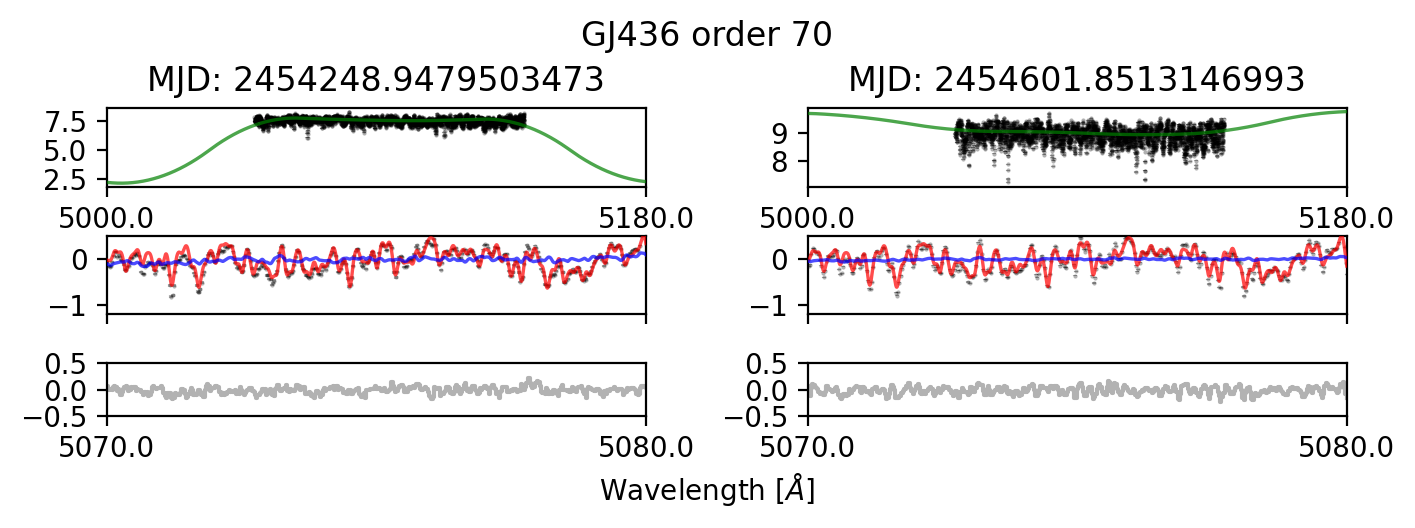

In [43]:
sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])

plt_epoches = [sorted_epoches[4],sorted_epoches[-1]]

fig, axes = plt.subplots(3,len(plt_epoches),figsize=(8,2),sharex=False,sharey=False,\
                             facecolor=(1, 1, 1),height_ratios=[3,3,2],dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])
# norm_dataset.to_device(cpus[0])

# lrange = np.linspace(int(np.mean(np.exp(dataset[plt_epoch].xs))),\
#                      int(np.mean(np.exp(dataset[plt_epoch].xs)))+10,4)[:,None]
lrange_n = np.linspace(5000,5180,2)[:,None]
epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    axes[0,ii] = make_subplot_norm(axes[0,ii],model,dataset,None,plt_epoch,cpus[0],lrange_n[:,0],nsigma=[0.5,2])
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    # axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])

    epoch_str += '.' + str(plt_epoch)
# plt_name = os.path.join(out_dir,"{}_spectra_norm_l{}-{}_e{}.png".format(star_name,lrange_n.min(),lrange_n.max(),epoch_str))

# fig.suptitle('{}_e{}'.format(star_name,epoch_str),y=0.95)
# fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
# plt.savefig(plt_name)
# plt.show()


# # sorted_epoches = np.argsort([dataframe.yivar.sum()for dataframe in dataset])
# # plt_epoches = [sorted_epoches[0],sorted_epoches[-1]]

# fig, axes = plt.subplots(2,len(plt_epoches),figsize=(8,2),sharex='col',sharey='row',\
#                              facecolor=(1, 1, 1),height_ratios=[3,1],dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])
# norm_dataset.to_device(cpus[0])

# plt_width = np.arange(-40,40,20) + 10
# plt_epoch = 19

# lrange = np.linspace(int(np.mean(np.exp(dataset[plt_epoch].xs))),\
#                      int(np.mean(np.exp(dataset[plt_epoch].xs)))+10,4)[:,None]

lrange = np.linspace(5070,5080,2)[:,None]
epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    # axes[0,ii] = make_subplot_norm(axes[0,ii],model,dataset,None,plt_epoch,cpus[0],lrange[:,0],nsigma=[0.5,3])
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    axes[1:,ii] = make_subplot(axes[1:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])
    # axes[0,ii].set_title('epoch {}'.format(plt_epoch))
    epoch_str += '.' + str(plt_epoch)
plt_name = os.path.join(out_dir,"{}_spectra_l{}-{}_e{}_o{}.png".format(star_name,\
                                                                       lrange.min(),lrange.max(),\
                                                                       epoch_str,echelle_order))

for ii,plt_epoch in enumerate(plt_epoches):
    time = dataset.metadata['times'][plt_epoch]
    print(time)
    axes[0,ii].set_title('MJD: {}'.format(time))
fig.suptitle('{} order {}'.format(star_name,echelle_order),y=1.1)
fig.text(0.5, -0.1, 'Wavelength [$\\AA$]', ha='center')
plt.subplots_adjust(hspace=0.7)
# fig.tight_layout() 
plt.savefig(plt_name,bbox_inches='tight')
plt.show()

In [19]:
def make_gascell_plot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    datablock = dataset.blockify(device,return_keys=True)
    
    datarow = datablock.ele(plt_epoch,device)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tell = model([],xplot,datarow['meta'])
    # yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    # velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Stellar Model        
    # Telluric M
    axes.plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.4,ms=3)

    axes.plot(datarow['xs'],datarow['ys'],'.g',zorder=10,alpha=0.4,ms=1)
 
    # axes.set_ylim(-1.2,0.5)
    axes.set_xticks(np.log(lrange))
    axes.set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

In [31]:
model.fit()
model.display()

-AdditiveModel--------------------------------------------------8684
  0-CompositeModel----------------------------------------------3590
  0  0-ShiftingModel---------------------------------------------188
  0  1-CardinalSplineMixture------------------------------------3402
  1-CompositeModel----------------------------------------------3778
  1  0-ShiftingModel---------------------------------------------188
  1  1-CardinalSplineMixture------------------------------------3402
  1  2-StretchingModel-------------------------------------------188
  2-CompositeModel----------------------------------------------1316
  2  0-ShiftingModel---------------------------------------------188
  2  1-NormalizationModel---------------------------------------1128


In [32]:
# plt_epoches = [0,0]

# lrange = np.array([np.linspace(5120,5128,2),np.linspace(5040,5060,2)])
# print(lrange.shape)

# fig, axes = plt.subplots(lrange.shape[1],1,figsize=(8,2),sharex=False,sharey='row',\
#                              facecolor=(1, 1, 1),dpi=200)

# plt.subplots_adjust(wspace=0.3)
# model.to_device(cpus[0])
# dataset.to_device(cpus[0])

# guess_vel = 0
# guess_shift = jabble.physics.shifts(guess_vel)

# epoch_str = ''
# # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
# for ii,plt_epoch in enumerate(plt_epoches):
    
#     axes[ii] = make_gascell_plot(axes[ii],np.log(iodine_tbl['wiod'])+guess_shift,\
#                                  0.5*(np.log(gas_conv)-np.log(gas_conv).mean()),\
#                                  model,dataset,plt_epoch,cpus[0],lrange[:,ii])
#     residuals  = 0.5*(np.log(gas_conv)-np.log(gas_conv).mean()) - model[1][1]([],np.log(iodine_tbl['wiod']))
#     # axes[ii,1].step(,where='mid')
#     # make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])
#     axes[ii].set_title('epoch {}'.format(plt_epoch))
#     axes[ii].set_ylim(-1,1)
#     epoch_str += '.' + str(plt_epoch)
# plt.subplots_adjust(hspace=0.45)

# plt_name = os.path.join(out_dir,"{}_spectra_l{}-{}_e{}_o{}.png".format(star_name,\
#                                                                        lrange.min(),lrange.max(),\
#                                                                        epoch_str,echelle_order))

# fig.suptitle('{} order {}'.format(star_name,echelle_order),y=1.1)
# fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
# plt.show()

In [53]:
def gaussian(xs,sigma):
    return 1/np.sqrt(2*sigma**2*np.pi)*jnp.exp(-xs**2/(2 *sigma**2))

def uneven_convolve_gauss(xs,ys,sigma,srange):
    def _internal(xss,yss):
        kernel = gaussian(xss,sigma)
        return jnp.dot(yss,kernel)/jnp.sqrt(jnp.dot(kernel,kernel))
        
    mean_diff = np.diff(xs).mean()
    ind_range = int(srange*sigma/mean_diff)
    print(ind_range)
    print(ys.shape,xs.shape)

    xss = np.zeros(shape=(len(xs),2*ind_range+1))
    yss = np.zeros(shape=(len(xs),2*ind_range+1))
    for i in range(len(xs)):
        temp = np.zeros((xss.shape[1]))
        temp_range = i + np.arange(-ind_range,ind_range+1,dtype=int)
        temp_index, = np.where((temp_range > 0)*(temp_range < len(xss)))
        xss[i,temp_index] = xs[temp_range[temp_index]] - xs[i]
        yss[i,temp_index] = ys[temp_range[temp_index]]
    
    return jax.vmap(_internal)(xss,yss)

iodine_tbl = scipy.io.readsav('../data/keck_fts_renorm.idl')
resolution = 110_000
sigma = jabble.physics.delta_x(resolution)
gas_conv = uneven_convolve_gauss(np.log(iodine_tbl['wiod']),iodine_tbl['siod'],sigma,10)
gas_snr = 10_000
guess_noise = np.ones(gas_conv.shape)/gas_snr

gas_dataset = jabble.dataset.Data.from_lists([np.log(iodine_tbl['wiod'])],[0.5*(np.log(gas_conv) - np.log(gas_conv).mean())],\
                                             [guess_noise],[np.zeros(gas_conv.shape)])

115
(296380,) (296380,)


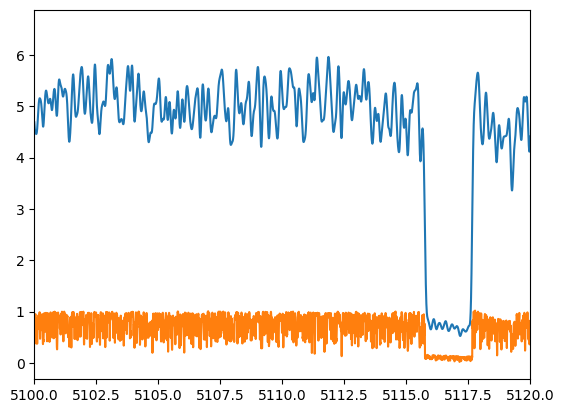

In [47]:
plt.plot(iodine_tbl['wiod'],gas_conv)
plt.plot(iodine_tbl['wiod'],iodine_tbl['siod'])
plt.xlim(5100,5120)
plt.show()

In [59]:
loss = jabble.loss.ChiSquare()
gas_model = jabble.model.CompositeModel([jabble.model.ShiftingModel([0]),model[1][1]])

cache_velocity = np.zeros(shape=(0,))
cache_loss = np.zeros(shape=(0,))

In [84]:
# print(loss_grid)
velocity_grid = np.linspace(700,900,2000).reshape(-1,100)*u.km/u.s
loss_grid = np.zeros(velocity_grid.shape)
for velocity_ii in range(velocity_grid.shape[0]):
    shift_grid = jabble.physics.shifts(velocity_grid[velocity_ii,:].to(u.m/u.s).value)[None,:]
    loss_grid[velocity_ii,:] = gas_model[0].grid_search(shift_grid,loss,gas_model,gas_dataset,cpus[0])
cache_velocity = np.concatenate((cache_velocity,velocity_grid.flatten()))
cache_loss = np.concatenate((cache_loss,loss_grid.flatten()))

/scratch/mdd423/.conda/envs/wobbleenv/lib/python3.9/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


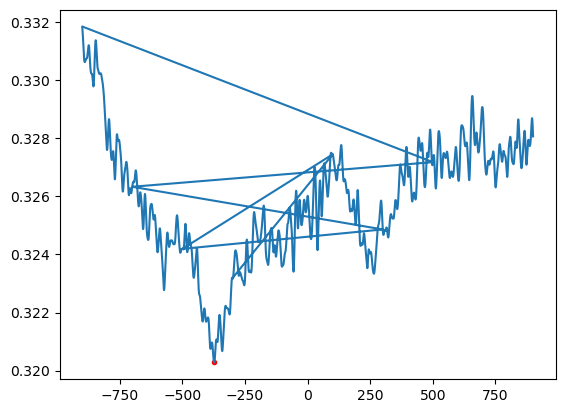

In [85]:
cache_index = np.argmin(cache_loss)
gas_model[0].p = gas_model[0].p.at[0].set(jabble.physics.shifts(cache_velocity[cache_index].to(u.m/u.s).value))

plt.plot(cache_velocity[cache_index],cache_loss[cache_index],'.r')
plt.plot(cache_velocity,cache_loss)
plt.show()

(3, 2)


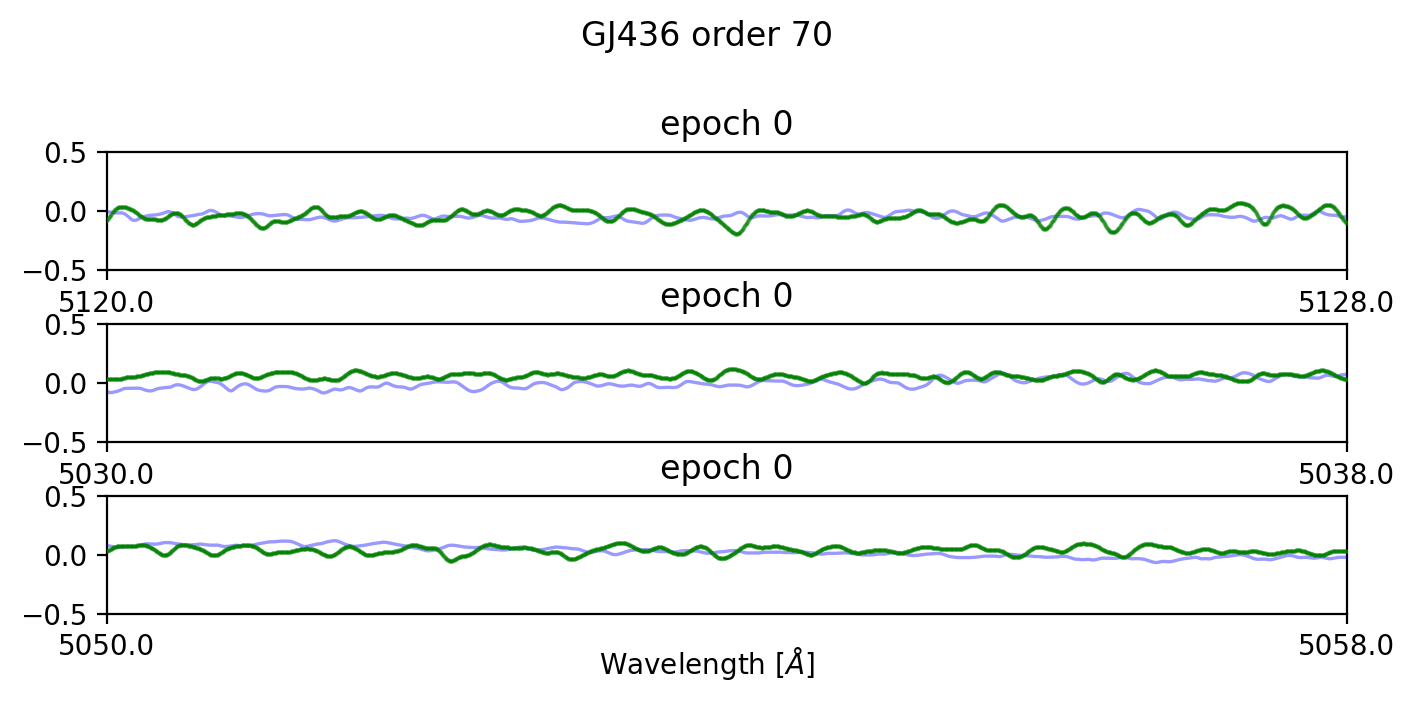

In [91]:
plt_epoches = [0,0,0]

lrange = np.array([np.linspace(5120,5128,2),np.linspace(5030,5038,2),np.linspace(5050,5058,2)])
print(lrange.shape)

fig, axes = plt.subplots(lrange.shape[0],1,figsize=(8,3),sharex=False,sharey='row',\
                             facecolor=(1, 1, 1),dpi=200)

plt.subplots_adjust(wspace=0.3)
model.to_device(cpus[0])
dataset.to_device(cpus[0])

guess_vel = 0
guess_shift = jabble.physics.shifts(guess_vel)

epoch_str = ''
# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
for ii,plt_epoch in enumerate(plt_epoches):
    
    axes[ii] = make_gascell_plot(axes[ii],
                                 gas_model,gas_dataset,plt_epoch,cpus[0],lrange[ii,:])
    # residuals  = 0.5*(np.log(gas_conv)-np.log(gas_conv).mean()) - model[1][1]([],np.log(iodine_tbl['wiod']))
    # axes[ii,1].step(,where='mid')
    # make_subplot(axes[:,ii],model,dataset,plt_epoch,cpus[0],lrange[:,0])
    axes[ii].set_title('epoch {}'.format(plt_epoch))
    axes[ii].set_ylim(-0.5,0.5)
    epoch_str += '.' + str(plt_epoch)
plt.subplots_adjust(hspace=0.45)

plt_name = os.path.join(out_dir,"{}_spectra_l{}-{}_e{}_o{}.png".format(star_name,\
                                                                       lrange.min(),lrange.max(),\
                                                                       epoch_str,echelle_order))

fig.suptitle('{} order {}'.format(star_name,echelle_order),y=1.1)
fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
plt.show()